<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 10. Бустинг
## <center>Часть 6. Борьба с недообучением и переобучением Xgboost

**Построим кривые вадидации Xgboost по числу деревьев в задаче классификации синтетических данных.**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import vstack
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, validation_curve
from xgboost.sklearn import XGBClassifier

**Генерируем синтетические данные.**

In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=8,
    n_redundant=3,
    n_repeated=2,
    random_state=42,
)

**Будем проводить 10-кратную стратифицированную кросс-валидацию. По умолчанию в статьях по машинному обучению и статистике используется именно такая.**

In [3]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

**Посмотрим, как число деревьев влияет на качество модели.**

In [4]:
default_params = {
    "objective": "binary:logistic",
    "max_depth": 1,
    "learning_rate": 0.3,
    "silent": 1.0,
    "seed": 42,
}

n_estimators_range = np.linspace(1, 200, 10).astype("int")

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X,
    y,
    param_name="n_estimators",
    param_range=n_estimators_range,
    cv=cv.split(X, y),
    scoring="accuracy",
    n_jobs=-1,
)

**Построим кривые валидации.**

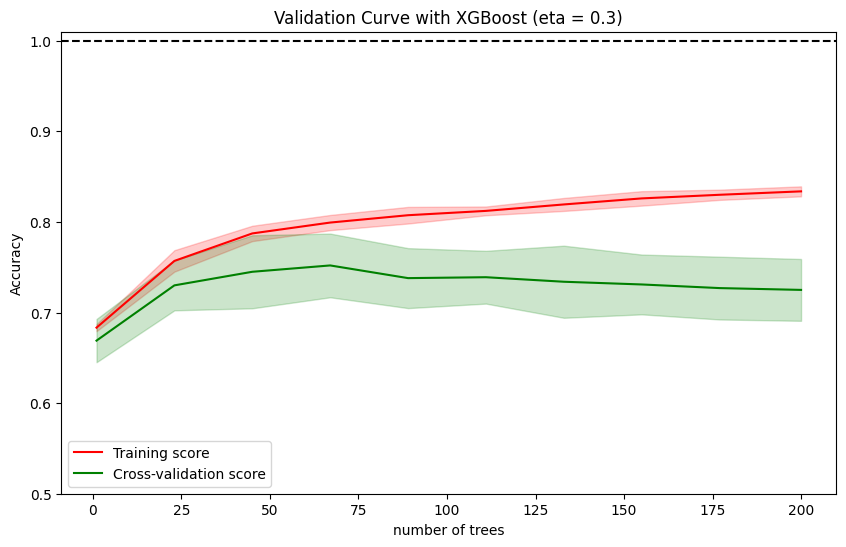

Best cross-validation result (0.75) obtained for 67 trees


In [5]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(n_estimators_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r",
)

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g",
)

plt.axhline(y=1, color="k", ls="dashed")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print(
    "Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
        test_scores_mean[i], n_estimators_range[i]
    )
)

**Что заметно:**

- Доля правильных ответов на обучении продолжает расти, хотя на валидации - уже нет
- Когда деревьев меньше 25 разброс (variance) ошибки невелик, но и смещение (bias) велико
- Начиная с 25 деревьев, разброс ошибки начинает расти
- Модель доаольно стабильна: дальнейшее увеличение ее сложности не приводит к увеличению разброса ошибки.

Оптимальное в данном случае сочетание разброса и смещение наблюдается примерно при 50 итерациях. Хотя разброс все же велик.

### Что можно улучшить?

#### Снижение разброса
Для уменьшения сложности модели можно:
- использовать меньше признаков (например, отбор)
- использовать больше объектов (например, искусственно созданных)
- увеличить регуляризацию

В случае XGBoost можно:
- уменьшать максимальную глубину деревьев(`max_depth`)
- увеличивать значение параметра `min_child_weight`
- увеличивать значение параметра `gamma`
- добавлять больше "случайности" за счет параметров `subsample` и `colsample_bytree`
- увеличивать значение паарметров регуляризации `lambda` и `alpha`

#### Снижение смещения
Если модель слишком простая, можно:
- добавлять больше признаков (например, изобретать их),
- усложнять модель
- уменьшать регуляризацию

В случае XGBoost можно:
- увеличивать максимальную глубину деревьев(`max_depth`)
- уменьшать значение параметра `min_child_weight`
- уменьшать значение параметра `gamma`
- уменьшать значение параметров регуляризации `lambda` и `alpha`

**Попробуем немного настроить параметры. Будем для построения каждого дерева использовать в среднем 70% случайно выбранных объектов и 60% случайно выбранных признаков. Это уменьшит разброс ошибки. Для уменьшения смещения увеличим на 1 максимальную глубину деревьев.**

In [6]:
new_params = {
    "objective": "binary:logistic",
    "max_depth": 2,  # changed
    "learning_rate": 0.3,
    "silent": 1.0,
    "colsample_bytree": 0.6,  # added
    "subsample": 0.7,  # added
    "seed": 42,
}

n_estimators_range = np.linspace(1, 200, 10).astype("int")

train_scores, test_scores = validation_curve(
    XGBClassifier(**new_params),
    X,
    y,
    param_name="n_estimators",
    param_range=n_estimators_range,
    cv=cv.split(X, y),
    scoring="accuracy",
)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:35:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

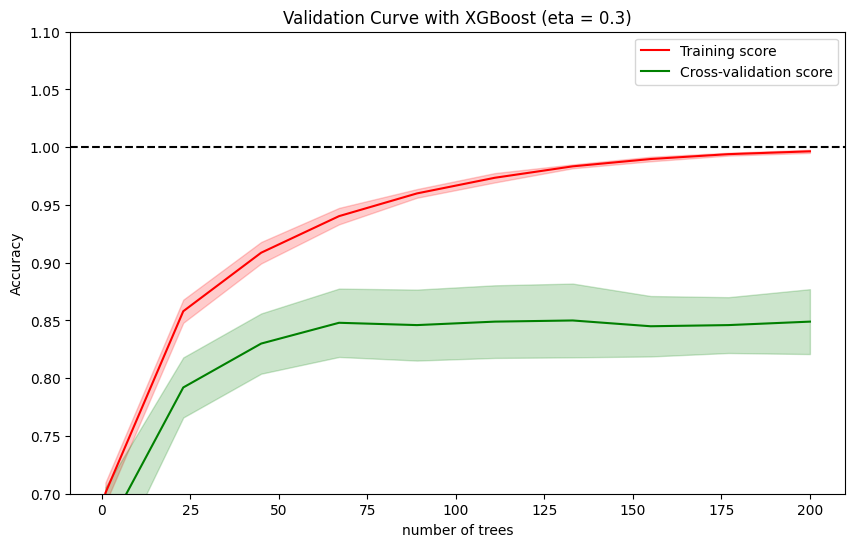

Best cross-validation result (0.85) obtained for 133 trees


In [7]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")

plt.plot(
    n_estimators_range, test_scores_mean, label="Cross-validation score", color="g"
)

plt.fill_between(
    n_estimators_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="r",
)

plt.fill_between(
    n_estimators_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="g",
)

plt.axhline(y=1, color="k", ls="dashed")

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print(
    "Best cross-validation result ({0:.2f}) obtained for {1} trees".format(
        test_scores_mean[i], n_estimators_range[i]
    )
)